In [38]:
!unzip data.zip

Archive:  data.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


In [39]:
# ## 1. Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

In [40]:
# ## 2. Data Loading and Cleaning
try:
    df = pd.read_csv("/content/data/googleplaystore.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'googleplaystore.csv' not found. Please check the file path.")
    df = pd.DataFrame()


Dataset loaded successfully.


In [41]:
if not df.empty:
    print(f"\nInitial dataset shape: {df.shape}")

    # ### 2.1. Data Cleaning
    print("\n--- Cleaning Data ---")
    # 이상치 행 제거 (리뷰 수가 비정상적인 데이터)
    df = df[df['Reviews'] != '3.0M']

    # 'Rating' 결측치 처리 (평균값으로 대체)
    mean_rating = pd.to_numeric(df['Rating'], errors='coerce').mean()
    df['Rating'].fillna(mean_rating, inplace=True)
    df['Rating'] = df['Rating'].astype(float)

    # 'Size' 컬럼 숫자형으로 변환
    df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', 'e+6') if 'M' in str(x) else x)
    df['Size'] = df['Size'].apply(lambda x: str(x).replace('k', 'e+3') if 'k' in str(x) else x)
    df['Size'] = df['Size'].replace('Varies with device', np.nan)
    df['Size'] = pd.to_numeric(df['Size'], errors='coerce')
    df['Size'].fillna(df['Size'].mean(), inplace=True)

    # 'Installs' 컬럼 숫자형으로 변환
    df['Installs'] = df['Installs'].apply(lambda x: str(x).replace('+', '') if '+' in str(x) else x)
    df['Installs'] = df['Installs'].apply(lambda x: str(x).replace(',', '') if ',' in str(x) else x)
    df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

    # 'Price' 컬럼 숫자형으로 변환
    df['Price'] = df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else x)
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

    # 'Reviews' 컬럼 숫자형으로 변환
    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

    # 나머지 결측치 처리 (최빈값으로 대체)
    for col in ['Type', 'Content Rating', 'Current Ver', 'Android Ver']:
        df[col].fillna(df[col].mode()[0], inplace=True)

    print("Data cleaning complete.")
    print("\nCleaned data info:")
    df.info()


Initial dataset shape: (10841, 13)

--- Cleaning Data ---
Data cleaning complete.

Cleaned data info:
<class 'pandas.core.frame.DataFrame'>
Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10840 non-null  object 
 1   Category        10840 non-null  object 
 2   Rating          10840 non-null  float64
 3   Reviews         10840 non-null  int64  
 4   Size            10840 non-null  float64
 5   Installs        10840 non-null  int64  
 6   Type            10840 non-null  object 
 7   Price           10840 non-null  float64
 8   Content Rating  10840 non-null  object 
 9   Genres          10840 non-null  object 
 10  Last Updated    10840 non-null  object 
 11  Current Ver     10840 non-null  object 
 12  Android Ver     10840 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 1.2+ MB


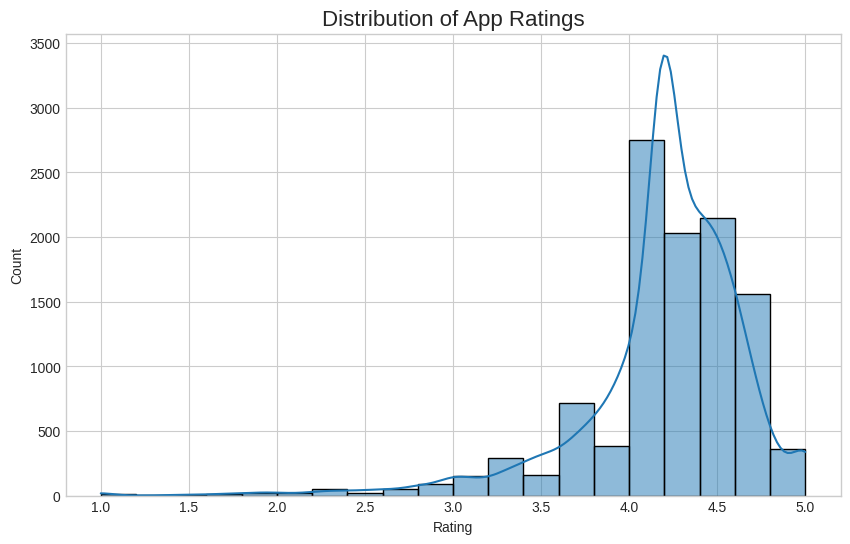

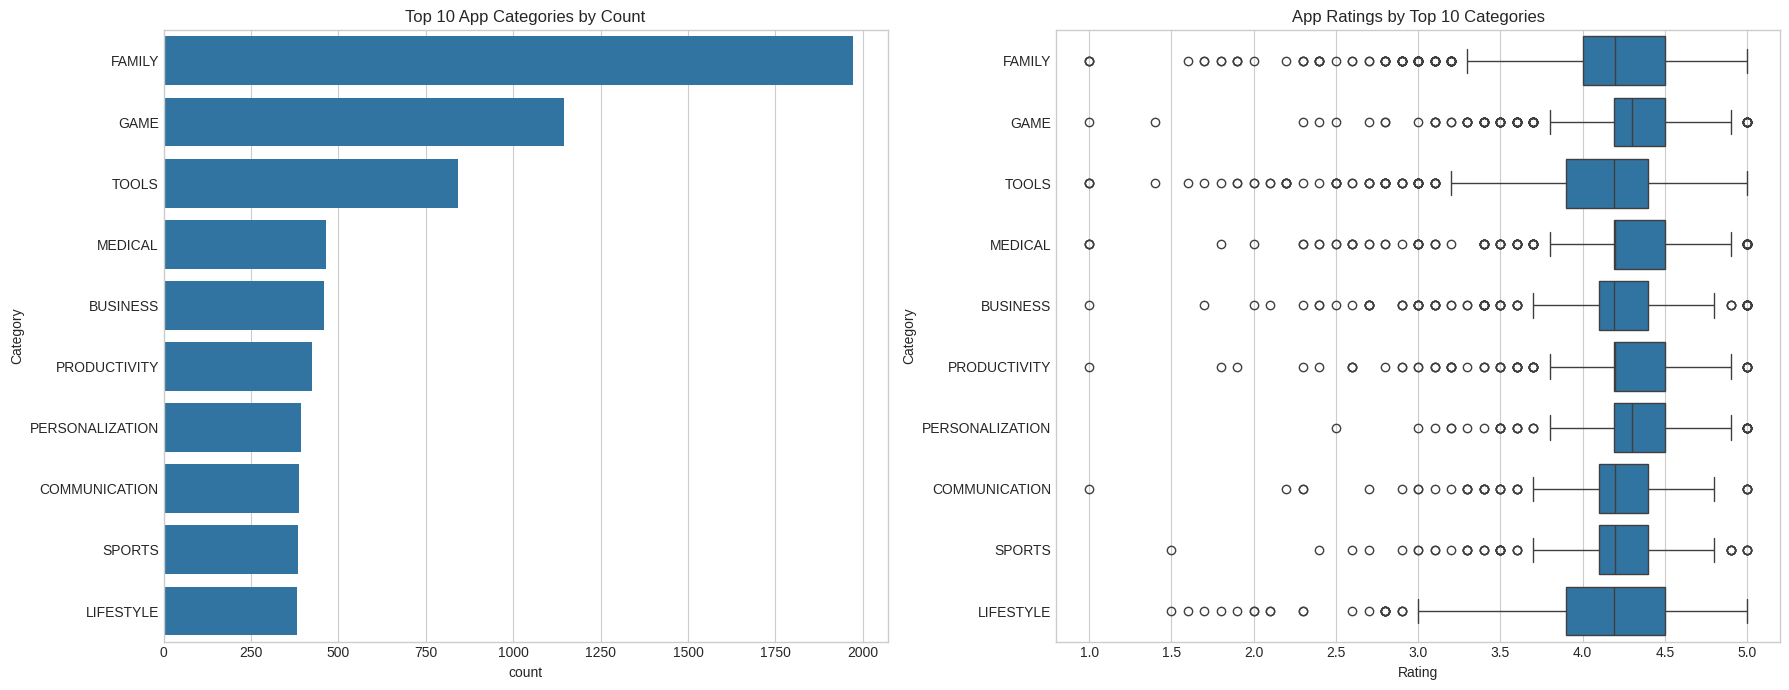

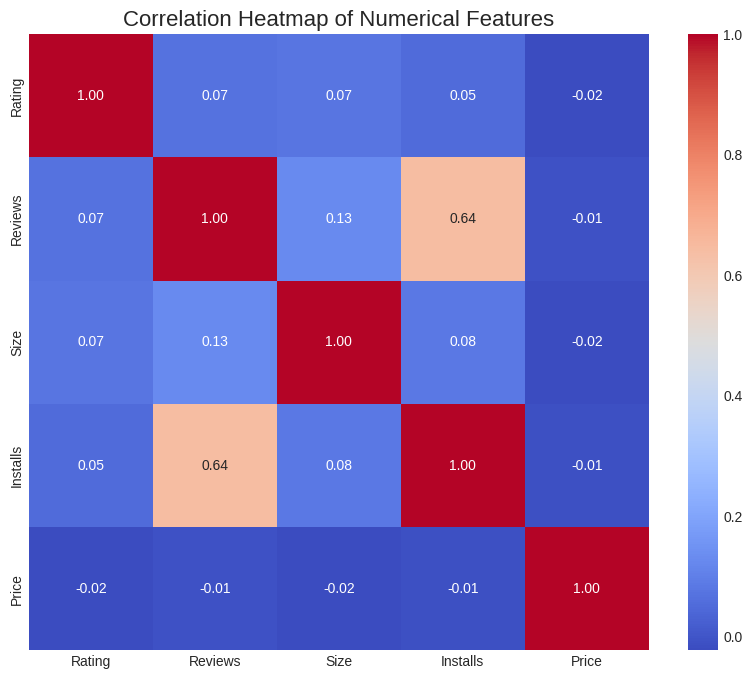

In [42]:
# ## 3. Exploratory Data Analysis (EDA)
if not df.empty:
    # 평점(Rating) 분포
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Rating'], bins=20, kde=True)
    plt.title('Distribution of App Ratings', fontsize=16)
    plt.show()

    # 상위 10개 카테고리 분포 및 평점
    top_categories = df['Category'].value_counts().nlargest(10).index
    df_top_cat = df[df['Category'].isin(top_categories)]

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    sns.countplot(y='Category', data=df_top_cat, order=top_categories, ax=axes[0])
    axes[0].set_title('Top 10 App Categories by Count')

    sns.boxplot(y='Category', x='Rating', data=df_top_cat, order=top_categories, ax=axes[1])
    axes[1].set_title('App Ratings by Top 10 Categories')
    plt.tight_layout()
    plt.show()

    # 수치형 변수 간 상관관계 히트맵
    plt.figure(figsize=(10, 8))
    corr_cols = ['Rating', 'Reviews', 'Size', 'Installs', 'Price']
    sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
    plt.show()

In [43]:
# ## 4. Feature Engineering and Preprocessing
if not df.empty:
    # 예측에 사용할 특성 선택 및 범주형 변수 원-핫 인코딩
    features_to_use = ['Reviews', 'Size', 'Installs', 'Price', 'Category', 'Content Rating', 'Type', 'Genres']
    target = 'Rating'

    df_model = df[features_to_use + [target]]
    df_model = pd.get_dummies(df_model, columns=['Category', 'Content Rating', 'Type', 'Genres'], drop_first=True)

    X = df_model.drop(target, axis=1)
    y = df_model[target]

    # 훈련/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 데이터 스케일링
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print(f"\nTraining data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")


Training data shape: (8672, 160)
Test data shape: (2168, 160)


In [44]:
# ## 5. Model Training and Comparison
if not df.empty:
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=100),
        "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1)
    }

    results = {}

    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        score_rmse = rmse(y_test, y_pred)
        score_r2 = r2_score(y_test, y_pred)

        results[name] = {'RMSE': score_rmse, 'R2 Score': score_r2}
        print(f"RMSE on test data: {score_rmse:.4f}")
        print(f"R2 Score on test data: {score_r2:.4f}")

    results_df = pd.DataFrame(results).T
    print("\n--- Model Performance Comparison ---")
    print(results_df.sort_values(by='RMSE', ascending=True))


--- Training Linear Regression ---
RMSE on test data: 0.4607
R2 Score on test data: 0.0198

--- Training Random Forest ---
RMSE on test data: 0.4380
R2 Score on test data: 0.1137

--- Training LightGBM ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 8672, number of used features: 90
[LightGBM] [Info] Start training from score 4.191383
RMSE on test data: 0.4266
R2 Score on test data: 0.1595

--- Model Performance Comparison ---
                       RMSE  R2 Score
LightGBM           0.426564  0.159517
Random Forest      0.438044  0.113668
Linear Regression  0.460652  0.019819



--- Analysis of the Best Model: LightGBM ---


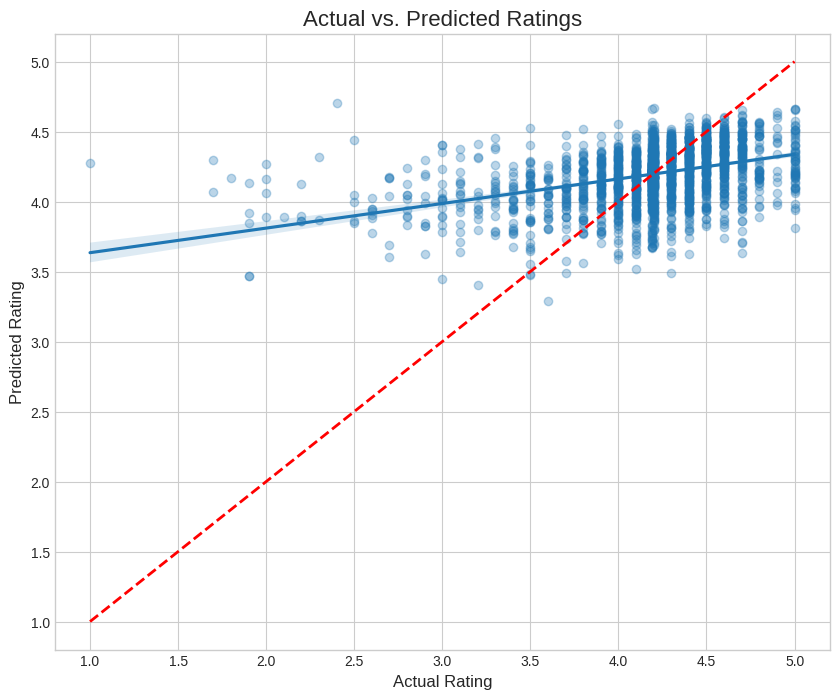

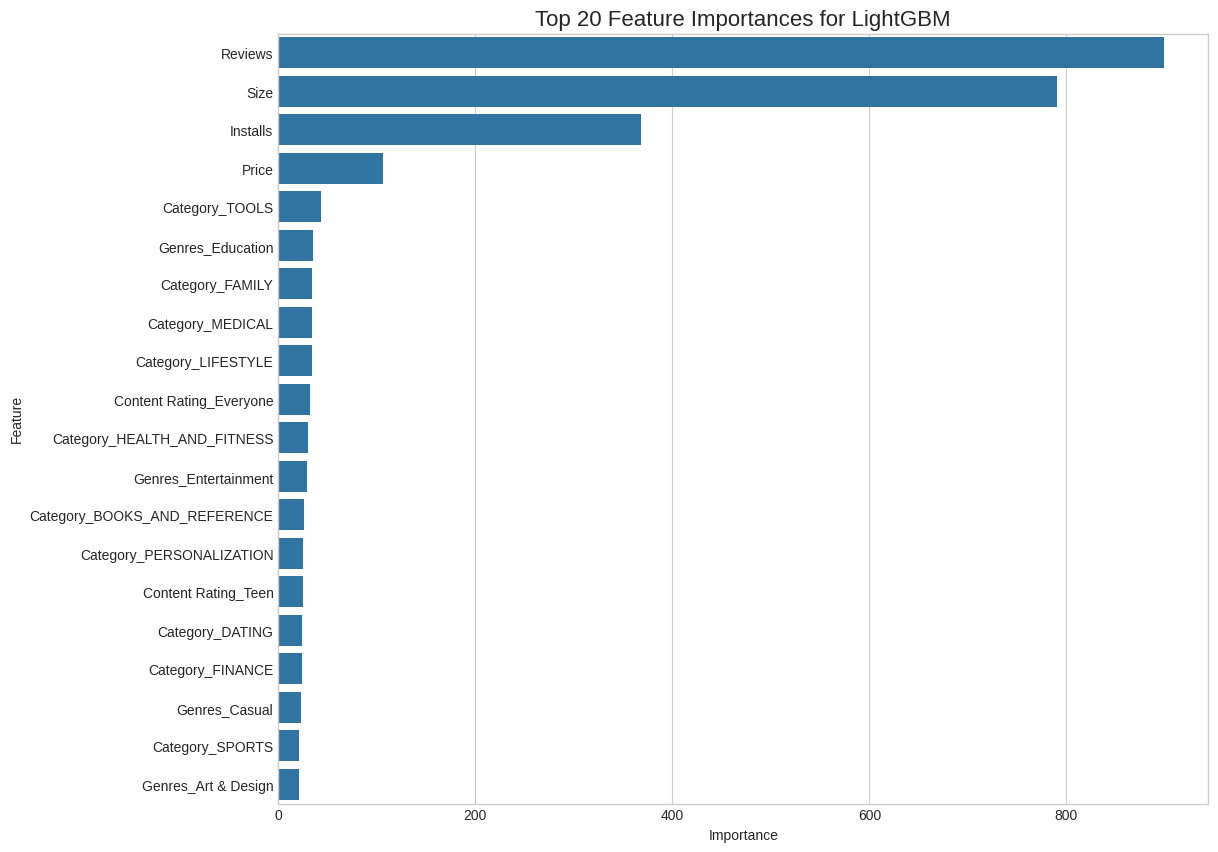

In [45]:
# ## 6. Results Analysis
if not df.empty:
    best_model_name = results_df['RMSE'].idxmin()
    best_model = models[best_model_name]
    print(f"\n--- Analysis of the Best Model: {best_model_name} ---")

    y_pred_best = best_model.predict(X_test)

    # 실제 값 vs 예측 값 비교 시각화
    plt.figure(figsize=(10, 8))
    sns.regplot(x=y_test, y=y_pred_best, scatter_kws={'alpha':0.3})
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2)
    plt.title('Actual vs. Predicted Ratings', fontsize=16)
    plt.xlabel('Actual Rating', fontsize=12)
    plt.ylabel('Predicted Rating', fontsize=12)
    plt.show()

    # 특성 중요도 분석 (Tree-based 모델인 경우)
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        # 원-핫 인코딩된 컬럼 이름 가져오기
        feature_names = X.columns
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(12, 10))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
        plt.title(f'Top 20 Feature Importances for {best_model_name}', fontsize=16)
        plt.show()